In [1]:
from IPython.display import Image

# HTML Document

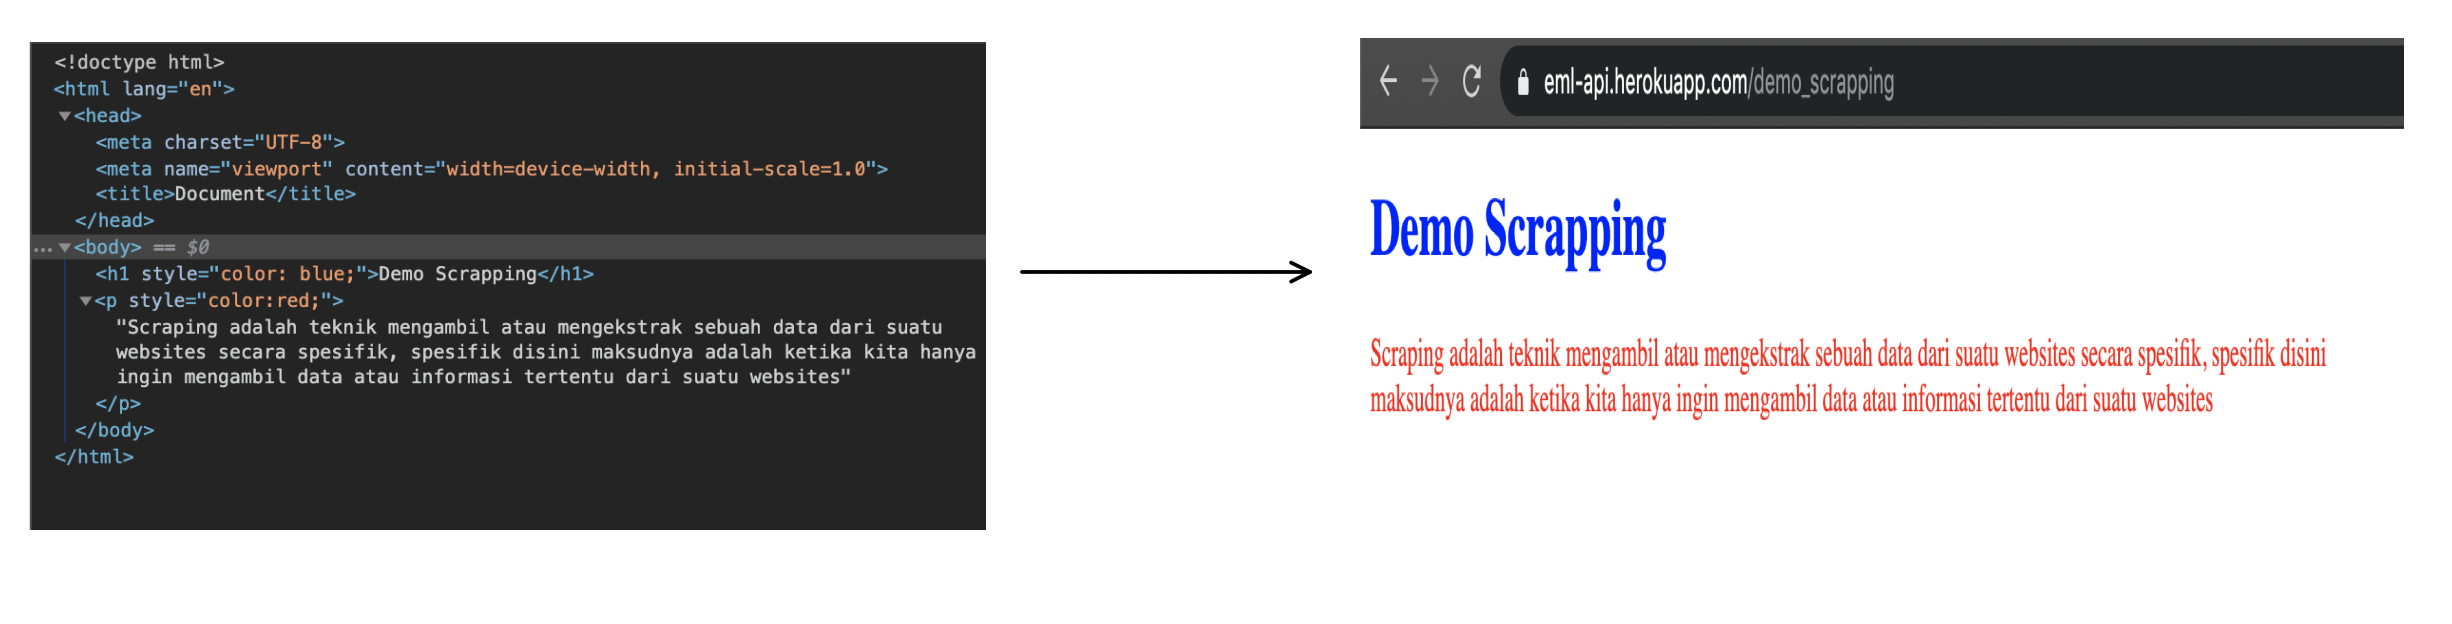

In [2]:
Image("assets/html_document.png")

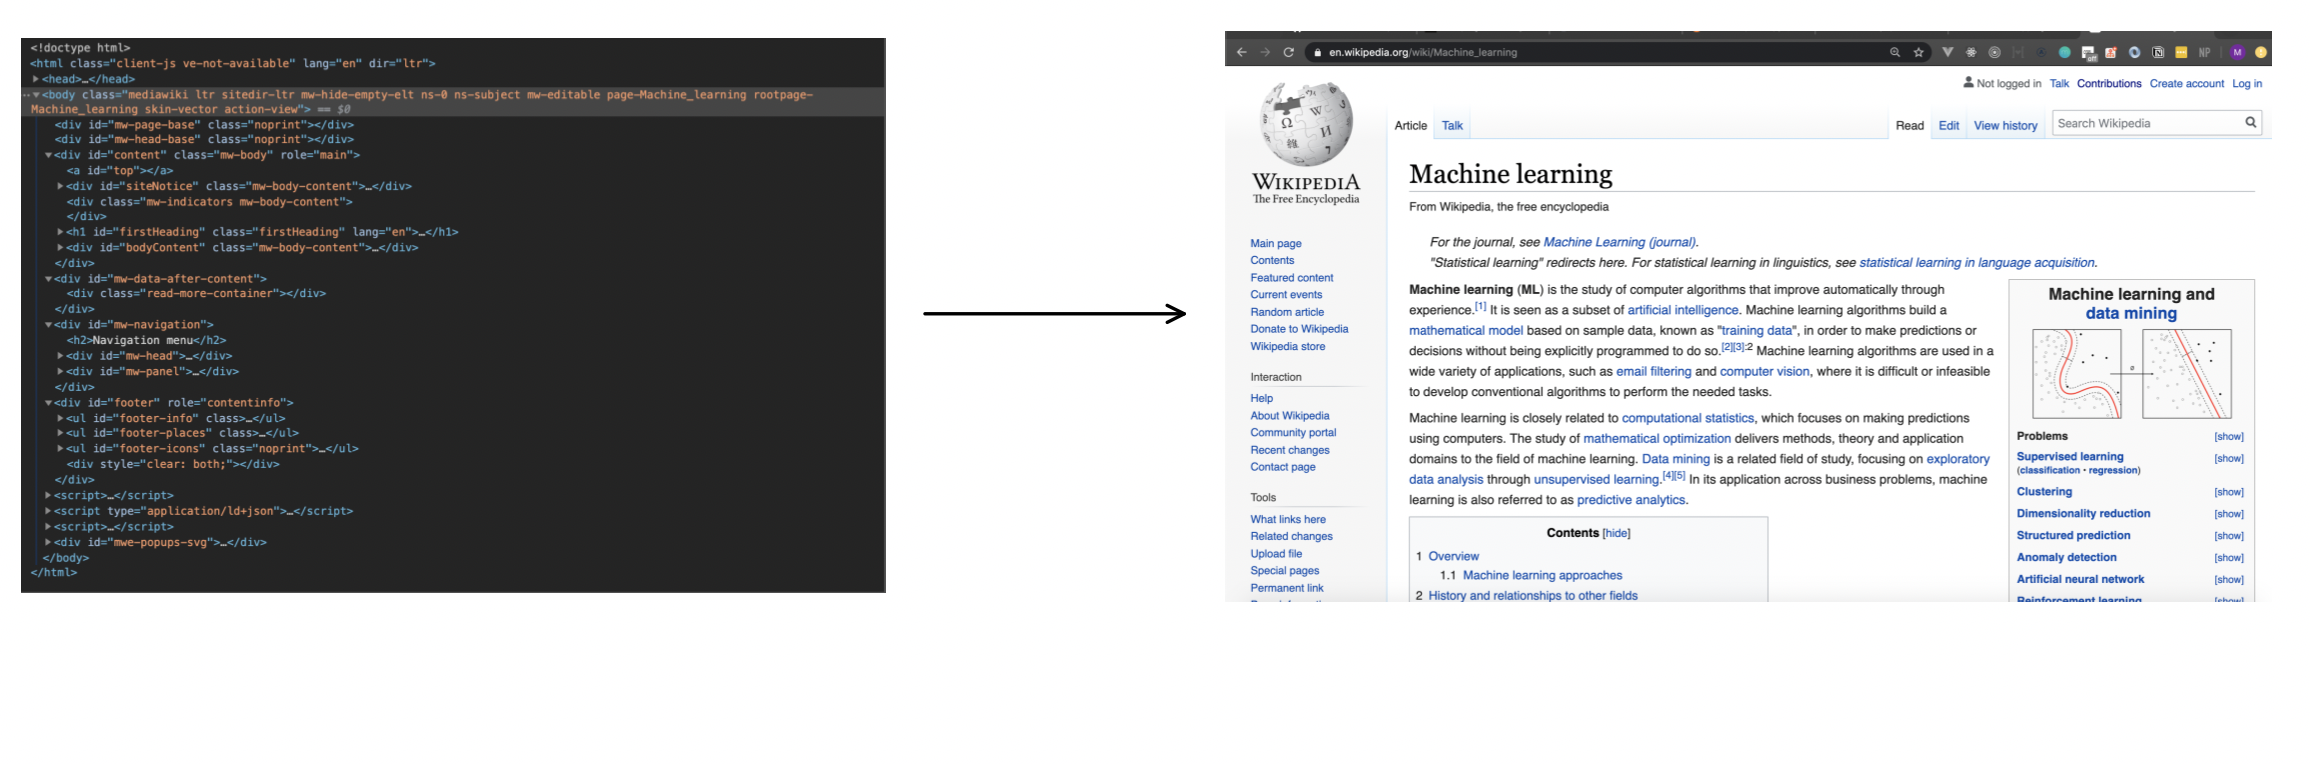

In [3]:
Image("assets/html_wikipedia.png")

# Scrapping

Scraping adalah teknik mengambil atau mengekstrak sebuah data dari suatu websites secara spesifik, spesifik disini maksudnya adalah ketika kita hanya ingin mengambil data atau informasi tertentu dari suatu websites

In [63]:
import requests
from bs4 import BeautifulSoup
from gensim.summarization import summarize
import re
from datetime import datetime

In [35]:
page = requests.get("https://eml-api.herokuapp.com/demo_scrapping")

In [36]:
soup = BeautifulSoup(page.content, 'html.parser')

In [37]:
soup.find('h1').get_text(), soup.find("p").get_text()

('Demo Scrapping',
 'Scraping adalah teknik mengambil atau mengekstrak sebuah data dari suatu websites secara spesifik, spesifik disini maksudnya adalah ketika kita hanya ingin mengambil data atau informasi tertentu dari suatu websites')

# News Scrapping

In [38]:
# Retrieve page text
url = 'https://www.npr.org/2019/07/10/740387601/university-of-texas-austin-promises-free-tuition-for-low-income-students-in-2020'
page = requests.get(url)

In [39]:
# Turn page into BeautifulSoup object to access HTML tags
soup = BeautifulSoup(page.content, "html.parser")

In [41]:
headline = soup.find('h1').get_text()
headline

'University of Texas-Austin Promises Free Tuition For Low-Income Students In 2020'

In [56]:
# Get text from all <p> tags.
p_tags = soup.find_all('p')
p_tags_text = [tag.get_text().strip() for tag in p_tags]
sentence_list = [sentence for sentence in p_tags_text if not '\n' in sentence]
sentence_list = [sentence for sentence in sentence_list if '.' in sentence]
# Combine list items into string.
article = ' '.join(sentence_list)

In [57]:
article

'Four year colleges and universities have difficulty recruiting talented students from the lower end of the economic spectrum who can\'t afford to attend such institutions without taking on massive debt. To remedy that — at least in part — the University of Texas-Austin announced it is offering full tuition scholarships to in-state undergraduates whose families make $65,000 or less per year. The University of Texas System Board of Regents voted unanimously on Tuesday to establish a $160 million endowment, drawing from the state\'s Permanent University Fund to begin the program in the fall of 2020. "Recognizing both the need for improved access to higher education and the high value of a UT Austin degree, we are dedicating a distribution from the Permanent University Fund to establish an endowment that will directly benefit students and make their degrees more affordable," Chairman of the Board of Regents Kevin Eltife said after the vote. "This will benefit students of our great state f

In [58]:
def scrap_news_article(url):
    # Retrieve page text
    url = url
    page = requests.get(url)
    # Turn page into BeautifulSoup object to access HTML tags
    soup = BeautifulSoup(page.content, "html.parser")
    headline = soup.find('h1').get_text()
    headline
    # Get text from all <p> tags.
    p_tags = soup.find_all('p')
    p_tags_text = [tag.get_text().strip() for tag in p_tags]
    sentence_list = [sentence for sentence in p_tags_text if not '\n' in sentence]
    sentence_list = [sentence for sentence in sentence_list if '.' in sentence]
    # Combine list items into string.
    article = ' '.join(sentence_list)
    return headline, article

In [60]:
# Retrieve page text
url = 'https://www.npr.org/'
page = requests.get(url)

In [61]:
# Turn page into BeautifulSoup object to access HTML tags
soup = BeautifulSoup(page.content)

In [62]:
# Get text from all <p> tags.
a_tags = soup.find_all('a', href=True)
a_tags = [a["href"] for a in a_tags if len(a["href"]) > 1]
a_tags = [a for a in a_tags if len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', a)) > 0]
a_tags = list(set([a for a in a_tags if re.search("^https://www.npr.org/sections", a) and re.search("\d", a)]))
a_tags = [[a] for a in a_tags]
a_tags

[['https://www.npr.org/sections/coronavirus-live-updates/2020/04/27/846377848/nearly-50-on-uss-kidd-test-positive-for-coronavirus-navy-confirms'],
 ['https://www.npr.org/sections/coronavirus-live-updates/2020/04/27/846197794/small-business-loans-site-crashes-on-1st-day-of-reopening'],
 ['https://www.npr.org/sections/coronavirus-live-updates/2020/04/27/846024717/even-the-la-lakers-got-a-ppp-small-business-loan'],
 ['https://www.npr.org/sections/coronavirus-live-updates/2020/04/27/846822592/calif-governor-warns-that-packed-beaches-put-coronavirus-pandemic-progress-at-ri'],
 ['https://www.npr.org/sections/goatsandsoda/2020/03/30/822491838/coronavirus-world-map-tracking-the-spread-of-the-outbreak'],
 ['https://www.npr.org/sections/coronavirus-live-updates/2020/04/27/846511124/irs-tells-thousands-to-return-to-work-with-their-own-face-masks'],
 ['https://www.npr.org/sections/coronavirus-live-updates/2020/04/27/846819966/boeing-ceo-sees-years-of-recovery-from-coronavirus-ahead-for-aviation-in

# Scrapping with PySpark

In [70]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import (
    StringType,
    ArrayType,
    IntegerType,
    FloatType,
    StructType,
    StructField,
    BooleanType,
    MapType,
    DateType
)
from pyspark.sql import functions as F

In [71]:
spark = SparkSession \
            .builder \
            .appName("EML Batch 9") \
            .getOrCreate()

sc = spark.sparkContext

In [79]:
schema_scrapper = StructType([
  StructField("url", StringType(), True)
])

rdd_scrapper_urls = sc.parallelize(a_tags)
df = spark.createDataFrame(rdd_scrapper_urls, schema_scrapper)

@F.udf(returnType=StringType())
def udf_fetch_html_docs(url):
    # Retrieve page text
    # url = 'https://www.npr.org/2019/07/10/740387601/university-of-texas-austin-promises-free-tuition-for-low-income-students-in-2020'
    page = requests.get(url)

    # Turn page into BeautifulSoup object to access HTML tags
    soup = BeautifulSoup(page.content)
    return f"{soup}"

@F.udf(returnType=StringType())
def udf_extract_article_body(docs):
    soup = BeautifulSoup(docs, "html.parser")
    # Get text from all <p> tags.
    p_tags = soup.find_all('p')
    # Get the text from each of the “p” tags and strip surrounding whitespace.
    p_tags_text = [tag.get_text().strip() for tag in p_tags]

    # Filter out sentences that contain newline characters '\n' or don't contain periods.
    sentence_list = [sentence for sentence in p_tags_text if not '\n' in sentence]
    sentence_list = [sentence for sentence in sentence_list if '.' in sentence]
    # Combine list items into string.
    article = ' '.join(sentence_list)
    return article

df = df \
  .withColumn("html_docs", udf_fetch_html_docs("url")) \
  .withColumn("headline", F.udf(lambda docs: BeautifulSoup(docs, "html.parser").find('h1').get_text(), StringType())(F.col("html_docs"))) \
  .withColumn("article", udf_extract_article_body("html_docs")) \
  .withColumn("summary", F.udf(lambda article: summarize(article, split=True)[0], StringType())(F.col("article"))) \
  .withColumn("release_date", F.udf(lambda url: datetime.strptime(f"{url.split('/')[6]}/{url.split('/')[7]}/{url.split('/')[5]}", "%m/%d/%Y"), DateType())(F.col("url"))) \
  .withColumn("category", F.udf(lambda url: url.split("/")[4], StringType())(F.col("url"))) \
  .drop("html_docs")
df.show(vertical=True)

-RECORD 0----------------------------
 url          | https://www.npr.o... 
 headline     | Nearly 50 On USS ... 
 article      | On Monday, the Na... 
 summary      | On Monday, the Na... 
 release_date | 2020-04-27           
 category     | coronavirus-live-... 
-RECORD 1----------------------------
 url          | https://www.npr.o... 
 headline     | Small Business Lo... 
 article      | Banks reported st... 
 summary      | Banks reported st... 
 release_date | 2020-04-27           
 category     | coronavirus-live-... 
-RECORD 2----------------------------
 url          | https://www.npr.o... 
 headline     | Even The Los Ange... 
 article      | The Los Angeles L... 
 summary      | The Los Angeles L... 
 release_date | 2020-04-27           
 category     | coronavirus-live-... 
-RECORD 3----------------------------
 url          | https://www.npr.o... 
 headline     | Calif. Governor W... 
 article      | People enjoy a da... 
 summary      | High temperatures... 
 release_dat

In [1]:
spark.stop()